# Machine Learning Project 1

## Regression analysis and resampling methods

### Import packages

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

### Define Franke function

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

### Test drawing of the Franke function

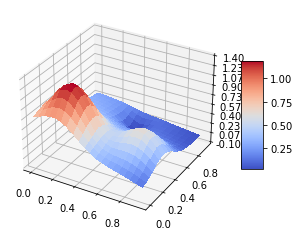

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [4]:
def create_X(x, y, n ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X


## Part a)

### Set up data

In [5]:
#number of points for each axis
n_points = 100

#set random seed
np.random.seed(1)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(2)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)

#generate normal distributed noise 
noise_amp = 0.1
noise = noise_amp*np.random.randn(X.shape[0])


#calculate starting target values with noise
z = FrankeFunction(X[:,1],X[:,2]) + noise


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)

### OLS regression 

In [6]:
def OLS(X_train, X_test, z_train, z_test):
    '''
    Fit the model with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    return z_train_tilde_ols, z_test_tilde_ols

0.011534306185200535
0.012239239023894517
0.8613384445592099
0.8602663919469787


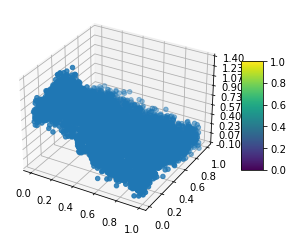

In [7]:
#apply OLS regression
z_train_tilde_ols, z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)

#calculate train and test mse 
mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)

print(mse_test)
print(mse_train)

print(r2_test)
print(r2_train)



fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.scatter3D(X[:,1],X[:,2], z, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Part b)

### Analysis of MSE as a function of complexity

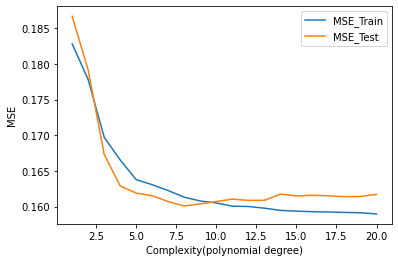

In [36]:
#number of points for each axis
n_points = 70

#set random seed
np.random.seed(10)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(2)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y,n=1)

#generate normal distributed noise 
noise_amp = 0.4
noise = noise_amp*np.random.randn(X0.shape[0])


#calculate starting target values with noise
z = FrankeFunction(X0[:,1],X0[:,2]) + noise

#maximum degree of polynomial
maxdegree = 20


#create arrays for results
polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))



#cycle on polynomial degrees

for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  
    

#plot the results
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Bootstrap method

In [59]:
#Important to split the data set before shuffling 
def bootstrap_OLS(X_train, z_train, X_test, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    z_test_tilde_ols = np.empty((len(z_test), n_bootstrap))
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        z_train_tilde_ols , z_test_tilde_ols[:,i] = OLS(X1_train, X_test, z1_train, z_test) 
        MSE[i,0] = mean_squared_error(z1_train,z_train_tilde_ols) 
        MSE[i,1] = mean_squared_error(z_test,z_test_tilde_ols[:,i])  
    return MSE, z_test_tilde_ols
# From now on, index 0 corresponds to train and 1 to test

### Check of central limit theorem

In [60]:
#number of resamplings
n_bootstrap = 3000


deg = 5
X = create_X(x,y,deg)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)

#calculation of mse over the resamplings
mse_bs, _ = bootstrap_OLS(X_train, z_train, X_test, z_test, n_bootstrap)
mse_bs_test = mse_bs[:,1]

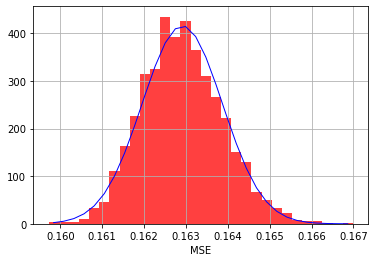

In [61]:
n, binsboot, patches = plt.hist(mse_bs_test, density=True, bins=30, facecolor='red', alpha=0.75)

# Why does density = True show thousands in the height of the bins?
# shouldn't it be normalized ?

#add a 'best fit' line   

bincenters = np.mean(np.vstack([binsboot[0:-1],binsboot[1:]]), axis=0)

Norm = norm.pdf(bincenters, np.mean(mse_bs_test), np.std(mse_bs_test))
lt = plt.plot(bincenters, Norm, 'b', linewidth=1)

plt.xlabel('MSE')
plt.ylabel('')
plt.grid(True)
plt.show()

### Bias-variance tradeoff with bootstrap method

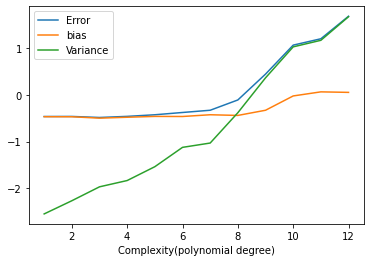

In [64]:
#number of points for each axis
n_points = 20

#set random seed
np.random.seed(1)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(2)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y,n=1)

#generate normal distributed noise 
noise_amp = 0.5
noise = noise_amp*np.random.randn(X0.shape[0])


#calculate starting target values with noise
z = FrankeFunction(X0[:,1],X0[:,2]) + noise



#maximum degree of polynomial
maxdegree = 12

#number of bootstrap resamplings
n_bs = 150


#create arrays for results
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2))



#cycle on polynomial degrees

for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, but it is necessary to test the same
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    #X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)
 
    mse,z_pred = bootstrap_OLS(X_train, z_train, X_test, z_test, n_bs )
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    error[degree] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
    MSE_boot[degree, 0] = np.mean(mse[:,0]) 
    MSE_boot[degree, 1] = np.mean(mse[:,1])   
    

#plot the results
plt.plot(polydegree, np.log10(error), label='Error')
plt.plot(polydegree, np.log10(bias), label='bias')
plt.plot(polydegree, np.log10(variance), label='Variance')
plt.xlabel('Complexity(polynomial degree)')
plt.legend()
plt.show()

### MSE analysis

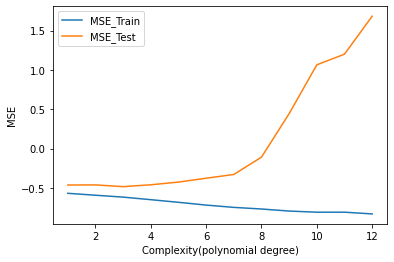

In [65]:
plt.figure()
plt.plot(polydegree,np.log10(MSE_boot[:,0]),label='MSE_Train')
plt.plot(polydegree,np.log10(MSE_boot[:,1]),label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Part c)

### Cross validation function

In [14]:
def cross_validation_OLS(k_folds, X,z):
    MSE = []
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)

        MSE.append( mean_squared_error(z_test, z_test_tilde_ols))

        return (np.mean(MSE))

### Division in k-folds

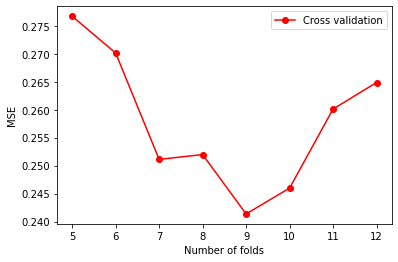

In [74]:
k_folds = range(5,13)
MSE_cross = np.zeros(len(k_folds))

maxdegree = 5
X = create_X(x,y,maxdegree)

for i in range(len(k_folds)):
    
    kfold = KFold(n_splits = k_folds[i])
    MSE_cross[i]=cross_validation_OLS(k,X,z)


plt.figure()
plt.plot(k_folds,MSE_cross,"o-",c="r",label="Cross validation")
plt.xlabel('Number of folds')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Comparison cross-validation and bootstrap

In [109]:
n_points = 20

maxdegree = 10


#number of bootstrap resamplings
n_bs = 100

#set random seed
np.random.seed(1)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(2)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y,n=1)

#generate normal distributed noise 
noise_amp = 0.05
noise = noise_amp*np.random.randn(X0.shape[0])

z = FrankeFunction(X0[:,1],X0[:,2]) + noise

MSE_test_boot = np.zeros(maxdegree)

k_folds = [5,10]

MSE_cross = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    X = create_X(x,y,degree)
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, but it is necessary to test the same
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
    
    mse,z_pred = bootstrap_OLS(X_train, z_train, X_test, z_test, n_bs )
    z_t = z_test.reshape(len(z_test),1)
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        kfold = KFold(n_splits = k)
        MSE_cross[degree,i] = cross_validation_OLS(k,X,z)


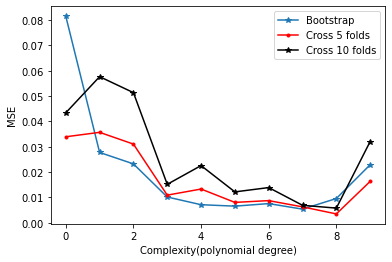

In [110]:
plt.figure()
plt.plot(range(maxdegree),MSE_test_boot,"*-",label = 'Bootstrap')
plt.plot(range(maxdegree),MSE_cross[:,0],"r.-", label ='Cross 5 folds' )
plt.plot(range(maxdegree),MSE_cross[:,1],"k*-", label = 'Cross 10 folds' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Part d)

### Ridge regression function

_Do we have to remove the intercept ? 
In all other cases we have kept it._

In [156]:
def Ridge(lambd,X_train,z_train,X_test):
    MSE_Ridge = np.zeros(2)
    # Since it relates to remove intercepts, better to use built in function in SKL
    
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    RegRidge.fit(X_train,z_train)
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    MSE_Ridge[0] = mean_squared_error(z_train, z_tilde_train)
    MSE_Ridge[1] = mean_squared_error(z_test, z_tilde_test )
    return MSE_Ridge, z_tilde_test

### Fitting with Ridge regression over different $\lambda$

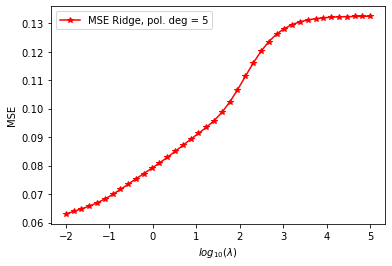

In [159]:
n_points = 20

degree = 5

#set random seed
np.random.seed(1)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(2)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X = create_X(x,y,deg)

#generate normal distributed noise 
noise_amp = 0.2
noise = noise_amp*np.random.randn(X0.shape[0])


z = FrankeFunction(X[:,1],X[:,2]) + noise

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)


#define interval of lambdas
nlambdas = 40
lambd = np.logspace(-2, 5, nlambdas)

MSE_test_Ridge = np.zeros(len(lambd))

#
for i in range(len(lambd)):
    MSE_Ridge,_ = Ridge(lambd[i],X_train,z_train,X_test)
    MSE_test_Ridge[i] = MSE_Ridge[1]
    

plt.figure()
plt.plot(np.log10(lambd), MSE_test_Ridge, 'r*-', label = 'MSE Ridge, pol. deg = {}'.format(deg))

plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Ridge regression with bootstrap

In [160]:
#Important to split the data set before shuffling 
def bootstrap_Ridge(X_train, z_train, X_test, z_test, n_bootstrap, lambd): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    z_test_tilde = np.empty((len(z_test), n_bootstrap))
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        mse_Ridge, z_test_tilde[:,i] = Ridge(lambd, X1_train, z1_train,X_test)
        MSE[i,0] = mse_Ridge[0]
        MSE[i,1] = mse_Ridge[1] 

    return MSE, z_test_tilde

Graphs do not agree for $\lambda\sim0$ because of different approach with intercept between OLS and Ridge ?

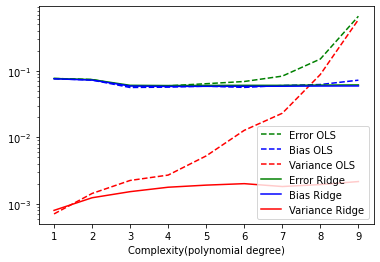

In [172]:
lambd = 10**-2
maxdegree = 9

n_bootstrap = 300

error_ols = np.zeros(maxdegree)
bias_ols = np.zeros(maxdegree)
variance_ols = np.zeros(maxdegree)

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

MSE_boot_ridge = np.zeros((maxdegree,2))
MSE_boot_ols = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    X = create_X(x,y,degree+1)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
 
    mse_ols, z_pred_ols = bootstrap_OLS(X_train, z_train, X_test, z_test, n_bootstrap)
    mse_ridge, z_pred_ridge = bootstrap_Ridge(X_train, z_train, X_test, z_test, n_bootstrap, lambd)
    
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    error_ridge[degree] = np.mean( np.mean((z_t - z_pred_ridge)**2, axis=1, keepdims=True) )
    bias_ridge[degree] = np.mean( (z_t - np.mean(z_pred_ridge, axis=1, keepdims=True))**2 )
    variance_ridge[degree] = np.mean( np.var(z_pred_ridge, axis=1, keepdims=True) )
    
    error_ols[degree] = np.mean( np.mean((z_t - z_pred_ols)**2, axis=1, keepdims=True) )
    bias_ols[degree] = np.mean( (z_t - np.mean(z_pred_ols, axis=1, keepdims=True))**2 )
    variance_ols[degree] = np.mean( np.var(z_pred_ols, axis=1, keepdims=True) )
    
    
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1])  
    MSE_boot_ols[degree, 0] = np.mean(mse_ols[:,0]) 
    MSE_boot_ols[degree, 1] = np.mean(mse_ols[:,1])  
    
plt.plot(polydegree, error_ols, "--g" , label='Error OLS')
plt.plot(polydegree, bias_ols,"--b", label='Bias OLS')
plt.plot(polydegree, variance_ols, "--r", label='Variance OLS')

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

plt.yscale("log")

plt.legend()
plt.show()

In [173]:
MSE_boot_ridge

array([[0.06364836, 0.0768224 ],
       [0.05749349, 0.07390288],
       [0.04696282, 0.06064648],
       [0.04543029, 0.06015544],
       [0.04388549, 0.06048468],
       [0.04295486, 0.06061877],
       [0.04183113, 0.06057248],
       [0.04099209, 0.06111709],
       [0.04085317, 0.06147729]])

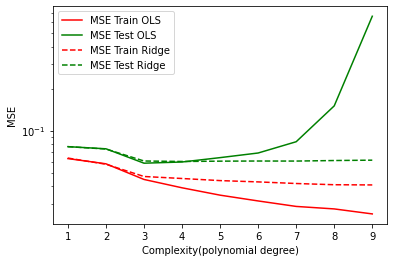

In [175]:
plt.figure()
plt.plot(polydegree,MSE_boot_ols[:,0],"r",label='MSE Train OLS')
plt.plot(polydegree,MSE_boot_ols[:,1],"g",label='MSE Test OLS')

plt.plot(polydegree,MSE_boot_ridge[:,0],"r--",label='MSE Train Ridge')
plt.plot(polydegree,MSE_boot_ridge[:,1],"g--",label='MSE Test Ridge')

plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')

plt.yscale("log")

plt.legend()
plt.show()

### Ridge regression with cross-validation 

In [169]:
def cross_validation_Ridge(k_folds, X,z,lambd):
    MSE = []
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        mse_Ridge, _ = Ridge(lambd, X_train, z_train)

        MSE.append( mse_Ridge[1])

        return (np.mean(MSE))

In [24]:
maxdegree = 10
n_samples = 20
lambd = 10
np.random.seed(1)
x0 = np.random.rand(n_samples)
np.random.seed(2)
y0 = np.random.rand(n_samples)

x,y = np.meshgrid(x0,y0)
X_ = create_X(x,y,maxdegree)
noise = 0.1*np.random.randn(X_.shape[0])

z = FrankeFunction(X_[:,1],X_[:,2]) + noise
MSE_test_boot = np.zeros(maxdegree)
k_folds = [5,10]
MSE_cross = np.zeros((maxdegree,2))
for degree in range(maxdegree):
    X = create_X(x,y,degree+1)
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, but it is necessary to test the same
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    mse,_ = bootstrap_Ridge(X_train, z_train,300, lambd)
    z_t = z_test.reshape(len(z_test),1)
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        kfold = KFold(n_splits = k)
        MSE_cross[degree,i] = cross_validation_Ridge(k,X,z,lambd)




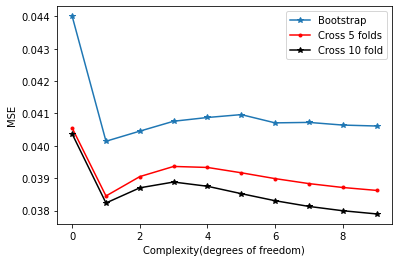

In [25]:
plt.figure()
plt.plot(range(maxdegree),MSE_test_boot,"*-",label = 'Bootstrap')
plt.plot(range(maxdegree),MSE_cross[:,0],"r.-", label ='Cross 5 folds' )
plt.plot(range(maxdegree),MSE_cross[:,1],"k*-", label = 'Cross 10 fold' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()